# **<font color="#FBBF44">Imports</font>**

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#!pip install gurobipy
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

# **<font color="#FBBF44">Functions</font>**

In [25]:
# Cost factors for large and Small vehicles
a1 = np.random.randint(5,10)/10 # = .8
a2 = a1*.75 # = .6

# Instance generator
def instance_gen(seed, clients, S1, S2, Q1, dmin, dmax):
    np.random.seed(seed) # Initial seed
    n = clients # number of clients
    # random location of clients within 8km radius
    xc = np.random.rand(n+1)*8 
    yc = np.random.rand(n+1)*8
    points = range(0,n+1)

    N = [i for i in range(1, n + 1)] # Set of clients
    V = [0] + N # Set of all nodes, including depot
    A = [(i,j) for i in V for j in V if i != j] # Available arcs between nodes
    
    S = S1 + S2 # Total amount of available vehicles
    K = [i for i in range(1, S + 1)] # Number of available vehicles, including large and small
    K1 = [i for i in range(1, S1 + 1)] # subset of large vehicles
    K2 = [i for i in range(S1+1, S1+S2+1)] # subset of small vehicles
    
    Ak = [(i,j,k) for k in K for i in V for j in V if i != j] # Available arcs between nodes for each vehicle
    Q = {} # Capacities
    for i in K:
        if i in K1:
            Q[i] = Q1 
        else:
            Q[i] = Q1/2

    d = {i: np.random.randint(dmin, dmax) for i in N} # Random demands from customers

    a1 = .8
    a2 = .6

    d1 = {(i,j,1): (np.hypot(xc[i] - xc[j], yc[i] - yc[j])) + np.random.rand() for i, j in A}
    d2 = {(i,j,2): d1[i,j,1] for i, j in A}
    c1 = {k:v*a1 for k, v in d1.items()} # Cost for traversing i,j with LargeVehicle
    c2 = {k:v*a2 for k, v in d2.items()} # Cost for traversing i,j with SmallVehicle
    c = dict(c1)
    c.update(c2) 
    return n, xc, yc, points, list(N), V, K, K1, K2, A, Ak, S, Q, d, c

In [26]:
# Building the model
def build_model():
    model = gp.Model(name)
    x = model.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
    y = model.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
    u = model.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
    z = model.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
    M = 1000000000 # Big M

    # objective
    model.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2), GRB.MINIMIZE)
    # (1)
    model.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
    # (2)
    model.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
    # (3)
    model.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
    # (4)
    model.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
    # (5)
    model.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
    # (6)
    model.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
    # (7)
    model.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
    # (8)
    model.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
    model.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)
    
    return model, x

In [27]:
# Plotting solution
def plot_sol(xc, yc, K1, K2, active_arcs, name):
    colors = []
    for i in range(len(active_arcs)):
        colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))

    plt.plot(xc[0], yc[0], c='red', marker='s', label="Depot")
    plt.scatter(xc[1:], yc[1:], label="Clients")
#     for i in range(len(xc)):
#         plt.annotate(points[i], (xc[i] - .5, yc[i] + 0.4))
    
    for k in K1:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k], lw=1.5, mutation_scale=15))
    for k in K2:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k], lw=1.5, mutation_scale=15))

    plt.xlim((-0.5, 8.5))
    plt.ylim((-0.5, 8.5))
    handles, labels = plt.gca().get_legend_handles_labels()
    lines = {}
    K = K1 + K2
    for k in K:
        if k in K1:
            lines[k] = Line2D([0], [0], label='LargeVehicle {}'.format(k), color = colors[k]) #, color='teal')
        else:
            lines[k] = Line2D([0], [0], label='SmallVehicle {}'.format(k), color = colors[k]) #, color='teal')

    handles.extend(lines.values())

    plt.legend(handles=handles, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
    plt.title("Optimal routes for {}".format(name))
    #plt.savefig("FigXX-Tour{}".format(name)+".png", bbox_inches='tight', dpi=600) 
    plt.show()

In [28]:
# Finding the edges from solution values, as a tuplelist for each k
def selected(vals):
    s = {k:gp.tuplelist() for k in K}
    for i, j, k in vals.keys():
        if vals[i,j,k] > 0.99:
            s[k].append((i,j))
    return s
       
# Given the edges, finding the optimal route for each k
def subtour(edges):
    nodes = set(i for e in edges for i in e)
    unvisited = list(nodes)
    cycle = list(nodes)
    while unvisited:  
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle): # even if it's the same, we reuse it so that we get the final tour in order
            cycle = thiscycle # New shortest subtour
    return cycle

# Print each tour
def print_route(objective, edges):
    print(f"The optimal cost for the distance traveled is: {(round(objective,2))} €")
    for k in K:
        tour = subtour(edges[k])
        tour.append(0) # return to depot
        print ("Route for vehicle k%i: %s" % (k, " -> ".join(map(str, tour))))

# **<font color="#BBBF">CHU INSTANCES</font>**

## **<font color="#FBBF44">CHU-01</font>**

In [29]:
times = []
objectives = []

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 131 rows, 90 columns and 440 nonzeros
Model fingerprint: 0x9736c319
Variable types: 0 continuous, 90 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e+00, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 45 rows and 5 columns
Presolve time: 0.00s
Presolved: 86 rows, 85 columns, 380 nonzeros
Variable types: 0 continuous, 85 integer (70 binary)

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H 

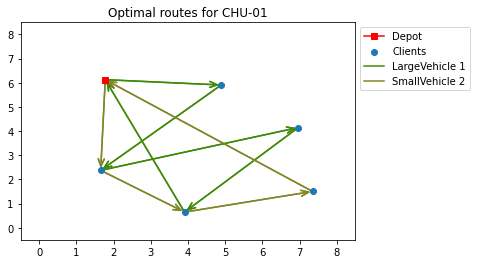

The optimal cost for the distance traveled is: 32.91 €
Route for vehicle k1: 0 -> 5 -> 2 -> 1 -> 4 -> 0
Route for vehicle k2: 0 -> 2 -> 4 -> 3 -> 0
Time to first solution = 0.023920059204101562


In [57]:
############ Instance Initialization CHU-01 ############
name = "CHU-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=5,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=30,
                                                                     dmin=7,
                                                                     dmax=10)
############ Model1 Construction ############
model1, x = build_model()

############ Model1 Solving ############
model1.reset()
model1.Params.SolutionLimit = 1
model1.optimize()

############ Plotting Solution ############
if model1.solcount >= 1:
    model1.write(name+".sol")
    model1.write(name+".mps")
    model1.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model1.getAttr('X', x)
    print_route(objective=model1.objVal, edges=selected(vals))
    print(f"Time to first solution = {model1.runtime}")
    times.append(model1.runtime)
    objectives.append(model1.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-02</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 456 rows, 280 columns and 1680 nonzeros
Model fingerprint: 0xa0005e19
Variable types: 0 continuous, 280 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [9e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 190 rows and 10 columns
Presolve time: 0.01s
Presolved: 266 rows, 270 columns, 1460 nonzeros
Variable types: 0 continuous, 270 integer (240 binary)

Root relaxation: objective 2.023748e+01, 105 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

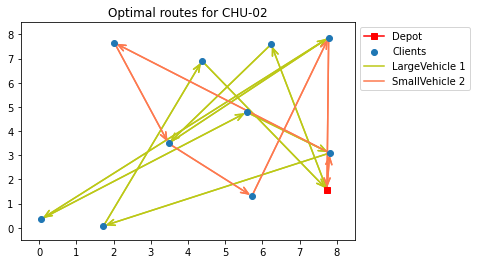

The optimal cost for the distance traveled is: 67.92 €
Route for vehicle k1: 0 -> 10 -> 9 -> 2 -> 7 -> 4 -> 6 -> 5 -> 1 -> 0
Route for vehicle k2: 0 -> 6 -> 8 -> 9 -> 3 -> 2 -> 0
Time to first solution = 0.05225372314453125


In [58]:
############ Instance Initialization CHU-02 ############
name = "CHU-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=10,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ Model Construction ############
model2, x = build_model()

############ model2 Solving ############
model2.reset()
model2.Params.SolutionLimit = 1
model2.optimize()

############ Plotting Solution ############
if model2.solcount >= 1:
    model2.write(name+".sol")
    model2.write(name+".mps")
    model2.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model2.getAttr('X', x)
    print_route(objective=model2.objVal, edges=selected(vals))
    print(f"Time to first solution = {model2.runtime}")
    times.append(model2.runtime)
    objectives.append(model2.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-03</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1464 rows, 855 columns and 5580 nonzeros
Model fingerprint: 0x4a3fb84e
Variable types: 0 continuous, 855 integer (765 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [6e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 630 rows and 0 columns
Presolve time: 0.01s
Presolved: 834 rows, 855 columns, 4905 nonzeros
Variable types: 0 continuous, 855 integer (765 binary)

Root relaxation: objective 2.725289e+01, 243 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

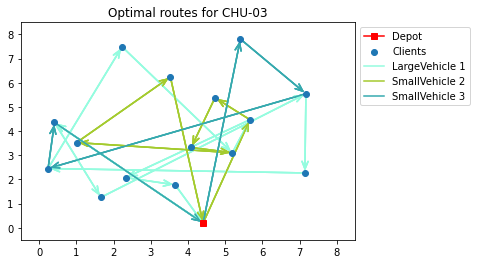

The optimal cost for the distance traveled is: 73.03 €
Route for vehicle k1: 0 -> 8 -> 7 -> 5 -> 4 -> 10 -> 13 -> 12 -> 1 -> 2 -> 11 -> 0
Route for vehicle k2: 0 -> 1 -> 15 -> 3 -> 12 -> 6 -> 9 -> 0
Route for vehicle k3: 0 -> 14 -> 5 -> 10 -> 8 -> 0
Time to first solution = 0.058841705322265625


In [59]:
############ Instance Initialization CHU-03 ############
name = "CHU-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=15,
                                                                     S1=1,
                                                                     S2=2,
                                                                     Q1=80,
                                                                     dmin=7,
                                                                     dmax=10)
############ model3 Construction ############
model3, x = build_model()

############ model3 Solving ############
model3.reset()
model3.Params.SolutionLimit = 1
model3.optimize()

############ Plotting Solution ############
if model3.solcount >= 1:
    model3.write(name+".sol")
    model3.write(name+".mps")
    model3.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model3.getAttr('X', x)
    print_route(objective=model3.objVal, edges=selected(vals))
    print(f"Time to first solution = {model3.runtime}")
    times.append(model3.runtime)
    objectives.append(model3.objVal)

else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-04</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3392 rows, 1920 columns and 13120 nonzeros
Model fingerprint: 0x8188c6ef
Variable types: 0 continuous, 1920 integer (1760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1520 rows and 0 columns
Presolve time: 0.03s
Presolved: 1872 rows, 1920 columns, 10000 nonzeros
Variable types: 0 continuous, 1920 integer (1760 binary)
Found heuristic solution: objective 124.8183372

Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.05 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 124.818 

Solution l

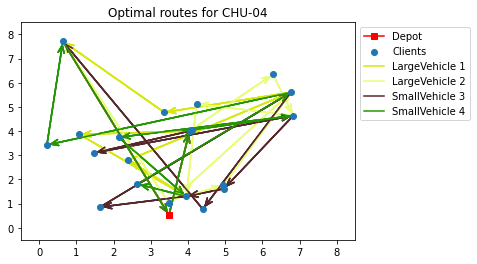

The optimal cost for the distance traveled is: 124.82 €
Route for vehicle k1: 0 -> 20 -> 12 -> 17 -> 8 -> 18 -> 4 -> 19 -> 0
Route for vehicle k2: 0 -> 20 -> 15 -> 16 -> 11 -> 17 -> 7 -> 18 -> 3 -> 19 -> 0
Route for vehicle k3: 0 -> 20 -> 14 -> 16 -> 10 -> 17 -> 6 -> 18 -> 2 -> 19 -> 0
Route for vehicle k4: 0 -> 20 -> 13 -> 16 -> 9 -> 17 -> 5 -> 18 -> 1 -> 19 -> 0
Time to first solution = 0.06682395935058594


In [60]:
############ Instance Initialization CHU-04 ############
name = "CHU-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=20,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ model4 Construction ############
model4, x = build_model()

############ model4 Solving ############
model4.reset()
model4.Params.SolutionLimit = 1
model4.optimize()

############ Plotting Solution ############
if model4.solcount >= 1:
    model4.write(name+".sol")
    model4.write(name+".mps")
    model4.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model4.getAttr('X', x)
    print_route(objective=model4.objVal, edges=selected(vals))
    print(f"Time to first solution = {model4.runtime}")
    times.append(model4.runtime)
    objectives.append(model4.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-05</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6540 rows, 3625 columns and 25500 nonzeros
Model fingerprint: 0xab0d39d5
Variable types: 0 continuous, 3625 integer (3375 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3000 rows and 0 columns
Presolve time: 0.06s
Presolved: 3540 rows, 3625 columns, 19375 nonzeros
Variable types: 0 continuous, 3625 integer (3375 binary)
Found heuristic solution: objective 187.6877317

Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.10 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 187.688 

Solution l

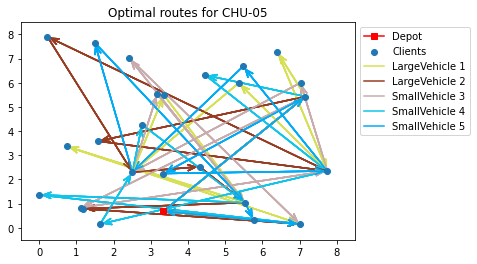

The optimal cost for the distance traveled is: 187.69 €
Route for vehicle k1: 0 -> 25 -> 20 -> 21 -> 15 -> 22 -> 10 -> 23 -> 5 -> 24 -> 0
Route for vehicle k2: 0 -> 25 -> 19 -> 21 -> 14 -> 22 -> 9 -> 23 -> 4 -> 24 -> 0
Route for vehicle k3: 0 -> 25 -> 18 -> 21 -> 13 -> 22 -> 8 -> 23 -> 3 -> 24 -> 0
Route for vehicle k4: 0 -> 25 -> 17 -> 21 -> 12 -> 22 -> 7 -> 23 -> 2 -> 24 -> 0
Route for vehicle k5: 0 -> 25 -> 16 -> 21 -> 11 -> 22 -> 6 -> 23 -> 1 -> 24 -> 0
Time to first solution = 0.11321640014648438


In [61]:
############ Instance Initialization CHU-05 ############
name = "CHU-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=25,
                                                                     S1=2,
                                                                     S2=3,
                                                                     Q1=75,
                                                                     dmin=7,
                                                                     dmax=10)
############ model5 Construction ############
model5, x = build_model()

############# model5 Solving ############
model5.reset()
model5.Params.SolutionLimit = 1
model5.optimize()

############ Plotting Solution ############
if model5.solcount >= 1:
    model5.write(name+".sol")
    model5.write(name+".mps")
    model5.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model5.getAttr('X', x)
    print_route(objective=model5.objVal, edges=selected(vals))
    print(f"Time to first solution = {model5.runtime}")
    times.append(model5.runtime)
    objectives.append(model5.objVal)
else:
    print("No feasible solution found")

# **<font color="#BBBF">CE INSTANCES</font>**

## **<font color="#FBBF44">CE-01</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6606 rows, 3520 columns and 25920 nonzeros
Model fingerprint: 0x5da7882e
Variable types: 0 continuous, 3520 integer (3360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3160 rows and 40 columns
Presolve time: 0.06s
Presolved: 3446 rows, 3480 columns, 19520 nonzeros
Variable types: 0 continuous, 3480 integer (3360 binary)

Root relaxation: objective 3.675523e+01, 612 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent

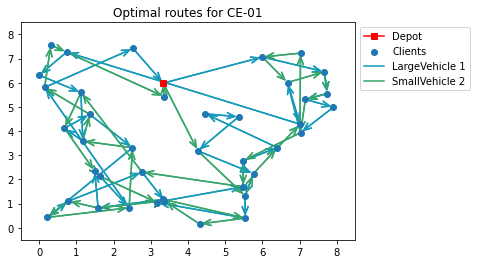

The optimal cost for the distance traveled is: 109.29 €
Route for vehicle k1: 0 -> 39 -> 32 -> 21 -> 25 -> 40 -> 13 -> 37 -> 24 -> 5 -> 2 -> 18 -> 4 -> 26 -> 28 -> 22 -> 14 -> 30 -> 7 -> 31 -> 11 -> 36 -> 20 -> 17 -> 15 -> 33 -> 1 -> 34 -> 23 -> 8 -> 16 -> 19 -> 6 -> 12 -> 3 -> 38 -> 35 -> 0
Route for vehicle k2: 0 -> 33 -> 34 -> 1 -> 20 -> 24 -> 29 -> 39 -> 37 -> 32 -> 21 -> 25 -> 13 -> 36 -> 11 -> 7 -> 18 -> 26 -> 6 -> 12 -> 8 -> 16 -> 23 -> 9 -> 31 -> 19 -> 30 -> 14 -> 3 -> 22 -> 4 -> 28 -> 38 -> 27 -> 5 -> 10 -> 0
Time to first solution = 0.7999324798583984


In [62]:
############ Instance Initialization CE-01 ############
name = "CE-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=40,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=400,
                                                                     dmin=12,
                                                                     dmax=15)
############ model6 Construction ############
model6, x = build_model()

############# model6 Solving ############
model6.reset()
model6.Params.SolutionLimit = 1
model6.optimize()

############ Plotting Solution ############
if model6.solcount >= 1:
    model6.write(name+".sol")
    model6.write(name+".mps")
    model6.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model6.getAttr('X', x)
    print_route(objective=model6.objVal, edges=selected(vals))
    print(f"Time to first solution = {model6.runtime}")
    times.append(model6.runtime)
    objectives.append(model6.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-02</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 30668 rows, 16200 columns and 121200 nonzeros
Model fingerprint: 0xa113bf10
Variable types: 0 continuous, 16200 integer (15600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 14700 rows and 0 columns
Presolve time: 0.28s
Presolved: 15968 rows, 16200 columns, 91500 nonzeros
Variable types: 0 continuous, 16200 integer (15600 binary)
Found heuristic solution: objective 289.1116566

Explored 0 nodes (0 simplex iterations) in 0.78 seconds (0.45 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 289.112 



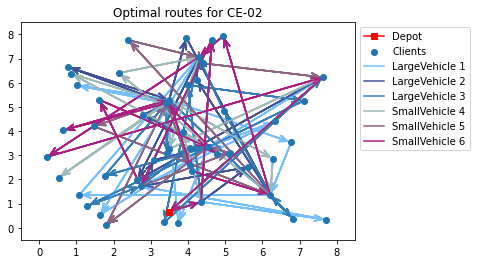

The optimal cost for the distance traveled is: 289.11 €
Route for vehicle k1: 0 -> 50 -> 40 -> 43 -> 36 -> 44 -> 30 -> 45 -> 24 -> 46 -> 18 -> 47 -> 12 -> 48 -> 6 -> 49 -> 0
Route for vehicle k2: 0 -> 50 -> 39 -> 43 -> 35 -> 44 -> 29 -> 45 -> 23 -> 46 -> 17 -> 47 -> 11 -> 48 -> 5 -> 49 -> 0
Route for vehicle k3: 0 -> 50 -> 41 -> 42 -> 38 -> 43 -> 34 -> 44 -> 28 -> 45 -> 22 -> 46 -> 16 -> 47 -> 10 -> 48 -> 4 -> 49 -> 0
Route for vehicle k4: 0 -> 50 -> 33 -> 44 -> 27 -> 45 -> 21 -> 46 -> 15 -> 47 -> 9 -> 48 -> 3 -> 49 -> 0
Route for vehicle k5: 0 -> 50 -> 37 -> 43 -> 32 -> 44 -> 26 -> 45 -> 20 -> 46 -> 14 -> 47 -> 8 -> 48 -> 2 -> 49 -> 0
Route for vehicle k6: 0 -> 50 -> 37 -> 43 -> 31 -> 44 -> 25 -> 45 -> 19 -> 46 -> 13 -> 47 -> 7 -> 48 -> 1 -> 49 -> 0
Time to first solution = 0.7836093902587891


In [63]:
############ Instance Initialization CE-02 ############
name = "CE-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=50,
                                                                     S1=3,
                                                                     S2=3,
                                                                     Q1=170,
                                                                     dmin=12,
                                                                     dmax=15)
############ model7 Construction ############
model7, x = build_model()

############ model7 Solving ############
model7.reset()
model7.Params.SolutionLimit = 1
model7.optimize()

############ Plotting Solution ############
if model7.solcount >= 1:
    model7.write(name+".sol")
    model7.write(name+".mps")
    model7.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model7.getAttr('X', x)
    print_route(objective=model7.objVal, edges=selected(vals))
    print(f"Time to first solution = {model7.runtime}")
    times.append(model7.runtime)
    objectives.append(model7.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-03</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 58644 rows, 30720 columns and 232320 nonzeros
Model fingerprint: 0x202d0645
Variable types: 0 continuous, 30720 integer (29760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 28320 rows and 0 columns
Presolve time: 0.66s
Presolved: 30324 rows, 30720 columns, 175200 nonzeros
Variable types: 0 continuous, 30720 integer (29760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Use crossover to convert LP symmetric solution to basic solution...
Concurrent spin time: 0.00s

Solved wi

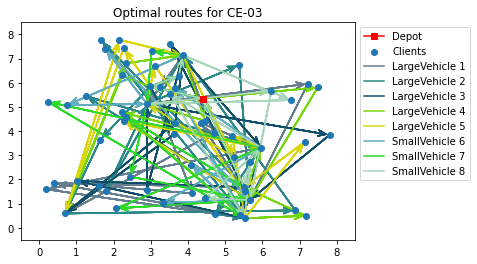

The optimal cost for the distance traveled is: 367.39 €
Route for vehicle k1: 0 -> 60 -> 52 -> 51 -> 53 -> 46 -> 54 -> 40 -> 55 -> 32 -> 56 -> 24 -> 57 -> 16 -> 58 -> 8 -> 59 -> 0
Route for vehicle k2: 0 -> 60 -> 50 -> 53 -> 45 -> 54 -> 39 -> 55 -> 31 -> 56 -> 23 -> 57 -> 15 -> 58 -> 7 -> 59 -> 0
Route for vehicle k3: 0 -> 60 -> 49 -> 53 -> 44 -> 54 -> 38 -> 55 -> 30 -> 56 -> 22 -> 57 -> 14 -> 58 -> 6 -> 59 -> 0
Route for vehicle k4: 0 -> 60 -> 48 -> 53 -> 43 -> 54 -> 37 -> 55 -> 29 -> 56 -> 21 -> 57 -> 13 -> 58 -> 5 -> 59 -> 0
Route for vehicle k5: 0 -> 60 -> 47 -> 53 -> 42 -> 54 -> 36 -> 55 -> 28 -> 56 -> 20 -> 57 -> 12 -> 58 -> 4 -> 59 -> 0
Route for vehicle k6: 0 -> 60 -> 41 -> 54 -> 35 -> 55 -> 27 -> 56 -> 19 -> 57 -> 11 -> 58 -> 3 -> 59 -> 0
Route for vehicle k7: 0 -> 60 -> 41 -> 54 -> 34 -> 55 -> 26 -> 56 -> 18 -> 57 -> 10 -> 58 -> 2 -> 59 -> 0
Route for vehicle k8: 0 -> 60 -> 41 -> 54 -> 33 -> 55 -> 25 -> 56 -> 17 -> 57 -> 9 -> 58 -> 1 -> 59 -> 0
Time to first solution = 2.5477

In [64]:
############ Instance Initialization CE-03 ############
name = "CE-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=60,
                                                                     S1=5,
                                                                     S2=3,
                                                                     Q1=140,
                                                                     dmin=12,
                                                                     dmax=15)
############ model8 Construction ############
model8, x = build_model()

############ model8 Solving ############
model8.reset()
model8.Params.SolutionLimit = 1
model8.optimize()

############ Plotting Solution ############
if model8.solcount >= 1:
    model8.write(name+".sol")
    model8.write(name+".mps")
    model8.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model8.getAttr('X', x)
    print_route(objective=model8.objVal, edges=selected(vals))
    print(f"Time to first solution = {model8.runtime}")
    times.append(model8.runtime)
    objectives.append(model8.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-04</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91299 rows, 47400 columns and 362400 nonzeros
Model fingerprint: 0x46578a66
Variable types: 0 continuous, 47400 integer (46200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 44400 rows and 0 columns
Presolve time: 0.87s
Presolved: 46899 rows, 47400 columns, 273000 nonzeros
Variable types: 0 continuous, 47400 integer (46200 binary)
Found heuristic solution: objective 470.8415003

Explored 0 nodes (0 simplex iterations) in 2.19 seconds (1.46 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 470.842 


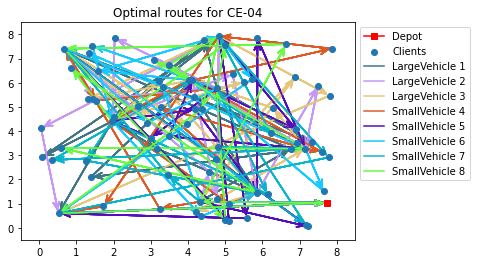

The optimal cost for the distance traveled is: 470.84 €
Route for vehicle k1: 0 -> 75 -> 64 -> 67 -> 56 -> 68 -> 48 -> 69 -> 40 -> 70 -> 32 -> 71 -> 24 -> 72 -> 16 -> 73 -> 8 -> 74 -> 0
Route for vehicle k2: 0 -> 75 -> 63 -> 67 -> 55 -> 68 -> 47 -> 69 -> 39 -> 70 -> 31 -> 71 -> 23 -> 72 -> 15 -> 73 -> 7 -> 74 -> 0
Route for vehicle k3: 0 -> 75 -> 65 -> 66 -> 62 -> 67 -> 54 -> 68 -> 46 -> 69 -> 38 -> 70 -> 30 -> 71 -> 22 -> 72 -> 14 -> 73 -> 6 -> 74 -> 0
Route for vehicle k4: 0 -> 75 -> 61 -> 67 -> 53 -> 68 -> 45 -> 69 -> 37 -> 70 -> 29 -> 71 -> 21 -> 72 -> 13 -> 73 -> 5 -> 74 -> 0
Route for vehicle k5: 0 -> 75 -> 60 -> 67 -> 52 -> 68 -> 44 -> 69 -> 36 -> 70 -> 28 -> 71 -> 20 -> 72 -> 12 -> 73 -> 4 -> 74 -> 0
Route for vehicle k6: 0 -> 75 -> 59 -> 67 -> 51 -> 68 -> 43 -> 69 -> 35 -> 70 -> 27 -> 71 -> 19 -> 72 -> 11 -> 73 -> 3 -> 74 -> 0
Route for vehicle k7: 0 -> 75 -> 57 -> 67 -> 50 -> 68 -> 42 -> 69 -> 34 -> 70 -> 26 -> 71 -> 18 -> 72 -> 10 -> 73 -> 2 -> 74 -> 0
Route for vehicle k8: 

In [65]:
############ Instance Initialization CE-04 ############
name = "CE-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=75,
                                                                     S1=3,
                                                                     S2=5,
                                                                     Q1=210,
                                                                     dmin=12,
                                                                     dmax=15)
############ model9 Construction ############
model9, x = build_model()

############ model9 Solving ############
model9.reset()
model9.Params.SolutionLimit = 1
model9.optimize()

############ Plotting Solution ############
if model9.solcount >= 1:
    model9.write(name+".sol")
    model9.write(name+".mps")
    model9.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model9.getAttr('X', x)
    print_route(objective=model9.objVal, edges=selected(vals))
    print(f"Time to first solution = {model9.runtime}")
    times.append(model9.runtime)
    objectives.append(model9.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-05</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 161724 rows, 83200 columns and 643200 nonzeros
Model fingerprint: 0x0e9329c6
Variable types: 0 continuous, 83200 integer (81600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 79200 rows and 0 columns
Presolve time: 2.18s
Presolved: 82524 rows, 83200 columns, 484000 nonzeros
Variable types: 0 continuous, 83200 integer (81600 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.505317

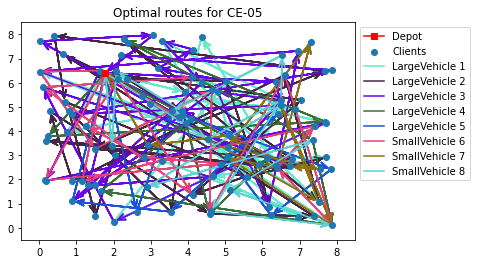

The optimal cost for the distance traveled is: 551.73 €
Route for vehicle k1: 0 -> 4 -> 56 -> 55 -> 20 -> 76 -> 21 -> 45 -> 32 -> 48 -> 16 -> 57 -> 27 -> 78 -> 1 -> 88 -> 99 -> 100 -> 83 -> 90 -> 94 -> 79 -> 77 -> 36 -> 96 -> 49 -> 92 -> 65 -> 0
Route for vehicle k2: 0 -> 11 -> 50 -> 18 -> 17 -> 86 -> 77 -> 12 -> 84 -> 29 -> 23 -> 28 -> 70 -> 53 -> 32 -> 27 -> 96 -> 30 -> 93 -> 8 -> 79 -> 64 -> 54 -> 67 -> 98 -> 43 -> 10 -> 92 -> 9 -> 74 -> 37 -> 14 -> 0
Route for vehicle k3: 0 -> 69 -> 61 -> 91 -> 39 -> 15 -> 26 -> 18 -> 47 -> 7 -> 16 -> 68 -> 81 -> 77 -> 71 -> 78 -> 48 -> 20 -> 50 -> 42 -> 36 -> 82 -> 92 -> 31 -> 34 -> 56 -> 55 -> 89 -> 60 -> 44 -> 85 -> 0
Route for vehicle k4: 0 -> 52 -> 87 -> 22 -> 3 -> 100 -> 2 -> 77 -> 98 -> 6 -> 0
Route for vehicle k5: 0 -> 24 -> 95 -> 46 -> 33 -> 57 -> 41 -> 12 -> 81 -> 0
Route for vehicle k6: 0 -> 97 -> 5 -> 75 -> 13 -> 21 -> 37 -> 89 -> 94 -> 45 -> 31 -> 36 -> 9 -> 19 -> 98 -> 64 -> 100 -> 96 -> 62 -> 99 -> 25 -> 0
Route for vehicle k7: 0 -> 

In [66]:
############ Instance Initialization CE-05 ############
name = "CE-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=100,
                                                                     S1=5,
                                                                     S2=3,
                                                                     Q1=250,
                                                                     dmin=12,
                                                                     dmax=15)
############ model10 Construction ############
model10, x = build_model()

############ model10 Solving ############
model10.reset()
model10.Params.SolutionLimit = 1
model10.optimize()

############ Plotting Solution ############
if model10.solcount >= 1:
    model10.write(name+".sol")
    model10.write(name+".mps")
    model10.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model10.getAttr('X', x)
    print_route(objective=model10.objVal, edges=selected(vals))
    print(f"Time to first solution = {model10.runtime}")
    times.append(model10.runtime)
    objectives.append(model10.objVal)
else:
    print("No feasible solution found")

# **<font color="#BBBF">G INSTANCES</font>**

## **<font color="#FBBF44">G-01</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 58206 rows, 29760 columns and 231360 nonzeros
Model fingerprint: 0x606113bf
Variable types: 0 continuous, 29760 integer (29280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [9e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 28680 rows and 120 columns
Presolve time: 0.44s
Presolved: 29526 rows, 29640 columns, 173760 nonzeros
Variable types: 0 continuous, 29640 integer (29280 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.544674e+01, 1298 iter

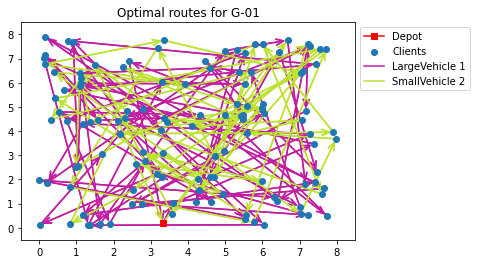

The optimal cost for the distance traveled is: 469.11 €
Route for vehicle k1: 0 -> 92 -> 117 -> 26 -> 15 -> 107 -> 30 -> 63 -> 120 -> 19 -> 31 -> 104 -> 48 -> 24 -> 118 -> 97 -> 111 -> 12 -> 81 -> 37 -> 25 -> 20 -> 96 -> 85 -> 22 -> 89 -> 73 -> 112 -> 17 -> 36 -> 71 -> 93 -> 114 -> 9 -> 21 -> 105 -> 56 -> 46 -> 4 -> 14 -> 88 -> 101 -> 108 -> 5 -> 95 -> 103 -> 57 -> 76 -> 106 -> 75 -> 61 -> 34 -> 18 -> 49 -> 90 -> 23 -> 2 -> 43 -> 50 -> 32 -> 7 -> 70 -> 8 -> 98 -> 52 -> 77 -> 94 -> 115 -> 28 -> 116 -> 3 -> 0
Route for vehicle k2: 0 -> 59 -> 41 -> 86 -> 11 -> 42 -> 66 -> 37 -> 45 -> 6 -> 29 -> 109 -> 113 -> 80 -> 67 -> 102 -> 65 -> 83 -> 39 -> 100 -> 99 -> 64 -> 54 -> 38 -> 10 -> 13 -> 103 -> 16 -> 33 -> 82 -> 69 -> 79 -> 110 -> 72 -> 27 -> 118 -> 58 -> 74 -> 60 -> 1 -> 87 -> 35 -> 44 -> 47 -> 111 -> 119 -> 96 -> 62 -> 55 -> 68 -> 51 -> 84 -> 40 -> 78 -> 91 -> 53 -> 0
Time to first solution = 26.65017318725586


In [48]:
############ Instance Initialization G-01 ############
name = "G-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=120,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=800,
                                                                     dmin=5,
                                                                     dmax=10)
############ model11 Construction ############
model11, x = build_model()

############ model1111 Solving ############
model11.reset()
model11.Params.SolutionLimit = 1
model11.optimize()

############ Plotting Solution ############
if model11.solcount >= 1:
    model11.write(name+".sol")
    model11.write(name+".mps")
    model11.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model11.getAttr('X', x)
    print_route(objective=model11.objVal, edges=selected(vals))
    print(f"Time to first solution = {model11.runtime}")
    times.append(model11.runtime)
    objectives.append(model11.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-02</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 118589 rows, 60480 columns and 472080 nonzeros
Model fingerprint: 0x342cf9e3
Variable types: 0 continuous, 60480 integer (59640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [7e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 58380 rows and 0 columns
Presolve time: 1.03s
Presolved: 60209 rows, 60480 columns, 354900 nonzeros
Variable types: 0 continuous, 60480 integer (59640 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 7.991289e+01, 2224 itera

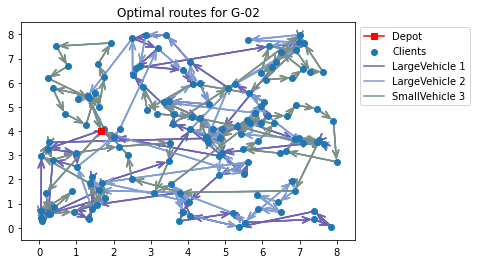

The optimal cost for the distance traveled is: 264.86 €
Route for vehicle k1: 0 -> 56 -> 32 -> 47 -> 37 -> 41 -> 89 -> 126 -> 69 -> 10 -> 135 -> 8 -> 128 -> 118 -> 82 -> 21 -> 26 -> 105 -> 79 -> 38 -> 81 -> 132 -> 7 -> 28 -> 54 -> 133 -> 74 -> 36 -> 49 -> 111 -> 136 -> 57 -> 67 -> 33 -> 4 -> 103 -> 15 -> 125 -> 121 -> 52 -> 11 -> 100 -> 138 -> 62 -> 5 -> 1 -> 39 -> 124 -> 80 -> 42 -> 2 -> 58 -> 119 -> 25 -> 117 -> 30 -> 88 -> 13 -> 20 -> 66 -> 137 -> 108 -> 90 -> 87 -> 92 -> 24 -> 59 -> 130 -> 83 -> 16 -> 113 -> 86 -> 104 -> 34 -> 23 -> 76 -> 120 -> 55 -> 3 -> 84 -> 17 -> 72 -> 127 -> 134 -> 139 -> 85 -> 0
Route for vehicle k2: 0 -> 21 -> 134 -> 11 -> 52 -> 82 -> 90 -> 113 -> 34 -> 18 -> 104 -> 16 -> 86 -> 87 -> 120 -> 76 -> 23 -> 105 -> 26 -> 128 -> 79 -> 53 -> 38 -> 36 -> 74 -> 101 -> 68 -> 96 -> 114 -> 12 -> 131 -> 7 -> 132 -> 49 -> 103 -> 33 -> 8 -> 111 -> 67 -> 37 -> 85 -> 6 -> 130 -> 1 -> 124 -> 80 -> 42 -> 138 -> 119 -> 58 -> 25 -> 117 -> 13 -> 55 -> 88 -> 66 -> 137 -> 108 -> 20

In [12]:
############ Instance Initialization G-02 ############
name = "G-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=22,
                                                                     clients=140,
                                                                     S1=2,
                                                                     S2=1,
                                                                     Q1=560,
                                                                     dmin=5,
                                                                     dmax=10)
############ model12 Construction ############
model12, x = build_model()

############ model12 Solving ############
model12.reset()
model12.Params.SolutionLimit = 1
model12.optimize()

############ Plotting Solution ############
if model12.solcount >= 1:
    model12.write(name+".sol")
    model12.write(name+".mps")
    model12.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model12.getAttr('X', x)
    print_route(objective=model12.objVal, edges=selected(vals))
    print(f"Time to first solution = {model12.runtime}")
    times.append(model12.runtime)
    objectives.append(model12.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-03</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 206252 rows, 104960 columns and 821760 nonzeros
Model fingerprint: 0x16a75baa
Variable types: 0 continuous, 104960 integer (103680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [9e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 101760 rows and 0 columns
Presolve time: 1.54s
Presolved: 104492 rows, 104960 columns, 617600 nonzeros
Variable types: 0 continuous, 104960 integer (103680 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    6756    

  1995  2062   87.98467  435  640          -   86.64851      -   175  422s
  2198  2207   88.55083  480  654          -   86.64851      -   169  434s
  2383  2367   91.30178  502  571          -   86.64851      -   165  447s
  2596  2530 infeasible  524               -   86.64851      -   160  460s
  2824  2663  124.51037  612  382          -   86.64851      -   155  474s
  2994  2778   86.64851   14 1039          -   86.64851      -   154  487s
  3126  2966   86.64851   30 1000          -   86.64851      -   154  502s
  3347  3128   86.68142   38  893          -   86.64851      -   150  515s
  3565  3316   87.03337   46  919          -   86.64851      -   145  529s
  3842  3514   86.66293   61  957          -   86.64851      -   137  564s
  4081  3753   86.81505   79  846          -   86.64851      -   132  578s
  4406  3997   86.70980   89  806          -   86.64851      -   126  593s
  4740  4247   86.72303   98  902          -   86.64851      -   120  608s
  5075  4447   86.73668  

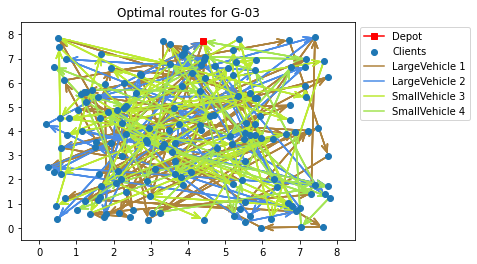

The optimal cost for the distance traveled is: 660.12 €
Route for vehicle k1: 0 -> 60 -> 139 -> 101 -> 10 -> 5 -> 43 -> 121 -> 52 -> 59 -> 53 -> 140 -> 83 -> 57 -> 100 -> 130 -> 89 -> 68 -> 155 -> 70 -> 149 -> 49 -> 20 -> 97 -> 45 -> 28 -> 103 -> 114 -> 84 -> 87 -> 1 -> 157 -> 147 -> 98 -> 22 -> 105 -> 153 -> 93 -> 15 -> 23 -> 150 -> 13 -> 91 -> 42 -> 26 -> 134 -> 95 -> 88 -> 136 -> 40 -> 29 -> 3 -> 37 -> 67 -> 141 -> 77 -> 14 -> 32 -> 132 -> 51 -> 92 -> 80 -> 160 -> 39 -> 27 -> 159 -> 17 -> 19 -> 151 -> 62 -> 0
Route for vehicle k2: 0 -> 155 -> 86 -> 41 -> 11 -> 135 -> 112 -> 107 -> 61 -> 99 -> 88 -> 44 -> 136 -> 15 -> 131 -> 49 -> 50 -> 138 -> 37 -> 66 -> 72 -> 106 -> 63 -> 114 -> 2 -> 119 -> 152 -> 123 -> 21 -> 117 -> 156 -> 10 -> 4 -> 73 -> 58 -> 140 -> 82 -> 16 -> 0
Route for vehicle k3: 0 -> 84 -> 22 -> 134 -> 102 -> 60 -> 104 -> 122 -> 125 -> 56 -> 142 -> 31 -> 158 -> 133 -> 159 -> 145 -> 52 -> 18 -> 81 -> 90 -> 155 -> 2 -> 12 -> 160 -> 11 -> 96 -> 35 -> 1 -> 7 -> 38 -> 71 -> 78

In [49]:
############ Instance Initialization G-03 ############
name = "G-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=160,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=650,
                                                                     dmin=5,
                                                                     dmax=10)
############ model13 Construction ############
model13, x = build_model()

############ model13 Solving ############
model13.reset()
model13.Params.SolutionLimit = 1
model13.optimize()

############ Plotting Solution ############
if model13.solcount >= 1:
    model13.write(name+".sol")
    model13.write(name+".mps")
    model13.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model13.getAttr('X', x)
    print_route(objective=model13.objVal, edges=selected(vals))
    print(f"Time to first solution = {model13.runtime}")
    times.append(model13.runtime)
    objectives.append(model13.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-04</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 260832 rows, 132480 columns and 1039680 nonzeros
Model fingerprint: 0x22c6357c
Variable types: 0 continuous, 132480 integer (131040 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [8e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 128880 rows and 0 columns
Presolve time: 1.94s
Presolved: 131952 rows, 132480 columns, 781200 nonzeros
Variable types: 0 continuous, 132480 integer (131040 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   

  3620  3223  365.85630 1370  100          -  101.11856      -  90.7  635s
  3984  3418  379.17661 1443   72          -  101.11856      -  84.5  653s
  4268  3631  395.98068 1508   58          -  101.11856      -  82.4  669s
  4561  3891  417.70832 1580   43          -  101.11856      -  79.7  685s
  4914  4187  433.09958 1657   32          -  101.11856      -  76.3  699s
  5321  4188  102.99171  207 1401          -  101.11856      -  71.7  716s
  5323  4189  106.45551  207 1238          -  101.11856      -  71.6  749s
  5324  4190  101.35300   28 1339          -  101.11856      -  71.6  772s
  5326  4191  206.66933  619 1521          -  101.11856      -  71.6  784s
  5327  4192  297.40628 1001 1499          -  101.11856      -  71.6  795s
  5329  4193  153.28989  466 1404          -  101.11856      -  71.6  800s
  5330  4194  101.35154   25 1444          -  101.11856      -  71.5  816s
  5331  4195  101.94441  217 1252          -  101.36537      -  71.5  846s
  5332  4195  102.90169  

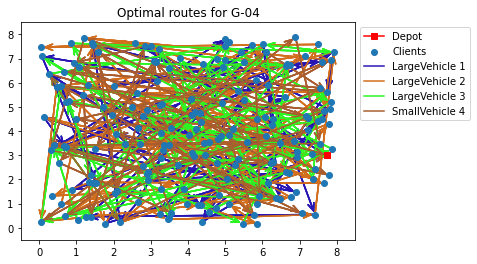

The optimal cost for the distance traveled is: 1027.91 €
Route for vehicle k1: 0 -> 163 -> 131 -> 135 -> 140 -> 46 -> 63 -> 6 -> 49 -> 116 -> 81 -> 3 -> 89 -> 34 -> 59 -> 128 -> 69 -> 12 -> 80 -> 101 -> 98 -> 8 -> 21 -> 153 -> 125 -> 41 -> 62 -> 133 -> 146 -> 42 -> 177 -> 117 -> 36 -> 48 -> 109 -> 16 -> 53 -> 150 -> 161 -> 92 -> 90 -> 130 -> 164 -> 152 -> 139 -> 149 -> 166 -> 171 -> 4 -> 1 -> 155 -> 178 -> 127 -> 156 -> 122 -> 167 -> 126 -> 154 -> 157 -> 176 -> 0
Route for vehicle k2: 0 -> 67 -> 99 -> 78 -> 153 -> 40 -> 54 -> 64 -> 129 -> 161 -> 2 -> 29 -> 25 -> 146 -> 144 -> 88 -> 143 -> 127 -> 171 -> 75 -> 77 -> 111 -> 136 -> 130 -> 70 -> 52 -> 167 -> 162 -> 166 -> 121 -> 139 -> 126 -> 178 -> 180 -> 152 -> 35 -> 60 -> 107 -> 147 -> 23 -> 158 -> 164 -> 179 -> 165 -> 44 -> 141 -> 31 -> 7 -> 163 -> 145 -> 160 -> 150 -> 71 -> 168 -> 114 -> 85 -> 175 -> 123 -> 174 -> 134 -> 108 -> 125 -> 131 -> 14 -> 170 -> 138 -> 28 -> 177 -> 84 -> 112 -> 18 -> 47 -> 57 -> 89 -> 149 -> 5 -> 19 -> 27 -> 1

In [50]:
############ Instance Initialization G-04 ############
name = "G-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=180,
                                                                     S1=3,
                                                                     S2=1,
                                                                     Q1=600,
                                                                     dmin=5,
                                                                     dmax=10)
############ model14 Construction ############
model14, x = build_model()

############ model14 Solving ############
model14.reset()
model14.Params.SolutionLimit = 1
model14.optimize()

############ Plotting Solution ############
if model14.solcount >= 1:
    model14.write(name+".sol")
    model14.write(name+".mps")
    model14.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model14.getAttr('X', x)
    print_route(objective=model14.objVal, edges=selected(vals))
    print(f"Time to first solution = {model14.runtime}")
    times.append(model14.runtime)
    objectives.append(model14.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-05</font>**

Discarded solution information
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 402215 rows, 204000 columns and 1604000 nonzeros
Model fingerprint: 0x56cc5866
Variable types: 0 continuous, 204000 integer (202000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 199000 rows and 0 columns
Presolve time: 4.45s
Presolved: 203215 rows, 204000 columns, 1205000 nonzeros
Variable types: 0 continuous, 204000 integer (202000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0  

   831   860  105.84198   80 1119          -  104.82449      -   159  618s
   861   904  105.68500   79 1105          -  104.82449      -   161  635s
   905   944  105.68448   85 1074          -  104.82449      -   160  658s
   945   967  105.72616   94 1092          -  104.82449      -   163  681s
   968  1002  105.70760   95 1258          -  104.82449      -   167  698s
  1003  1033  105.94473   96 1085          -  104.82449      -   171  721s
  1034  1070  105.80655   99 1121          -  104.82449      -   173  744s
  1071  1094  105.95901  104 1085          -  104.82449      -   177  767s
  1095  1130  105.82570  107 1064          -  104.82449      -   181  791s
  1131  1152  105.97718  106 1105          -  104.82449      -   185  817s
  1153  1192  105.97993  111  973          -  104.82449      -   190  839s
  1194  1234  106.05029  114 1068          -  104.82449      -   193  866s
  1236  1296  106.05029  115 1064          -  104.82449      -   196  895s
  1301  1332  106.27027  

  5296  4653  108.85562  232 2052          -  108.85562      -   223 3413s
  5297  4654  123.06530  651 1652          -  108.85945      -   223 3427s
  5300  4656  111.71216  522 1958          -  108.86045      -   222 3443s
  5301  4656  226.63931  997 1821          -  108.86358      -   222 3461s
  5302  4657  108.86358   87 2084          -  108.86358      -   222 3476s
  5303  4658  108.86400   87 1831          -  108.86400      -   222 3497s
  5304  4658  189.72166  906 1892          -  108.86400      -   222 3512s
  5305  4659  108.87173  241 1775          -  108.87173      -   222 3530s
  5307  4660  179.95780 1160 2065          -  108.87235      -   222 3544s
  5308  4661  108.87235  184 1579          -  108.87235      -   222 3558s
  5309  4662  111.83989  313 2073          -  108.87235      -   222 3572s
  5310  4662  150.31894  970 1481          -  108.88078      -   222 3590s
  5311  4663  108.88078  130 1754          -  108.88078      -   222 3602s
  5312  4664  108.89504  

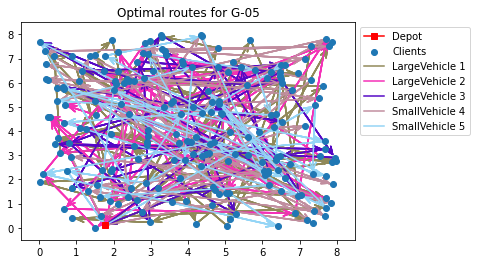

The optimal cost for the distance traveled is: 864.97 €
Route for vehicle k1: 0 -> 93 -> 147 -> 69 -> 172 -> 66 -> 199 -> 70 -> 54 -> 179 -> 5 -> 189 -> 123 -> 63 -> 82 -> 135 -> 27 -> 49 -> 186 -> 130 -> 187 -> 148 -> 57 -> 175 -> 97 -> 98 -> 169 -> 95 -> 109 -> 23 -> 133 -> 42 -> 131 -> 19 -> 88 -> 91 -> 117 -> 25 -> 167 -> 158 -> 9 -> 198 -> 106 -> 134 -> 193 -> 163 -> 120 -> 6 -> 107 -> 20 -> 16 -> 182 -> 39 -> 41 -> 44 -> 126 -> 50 -> 141 -> 1 -> 47 -> 192 -> 146 -> 142 -> 111 -> 176 -> 114 -> 96 -> 0
Route for vehicle k2: 0 -> 67 -> 73 -> 200 -> 140 -> 173 -> 153 -> 29 -> 89 -> 40 -> 128 -> 100 -> 12 -> 136 -> 90 -> 145 -> 18 -> 149 -> 72 -> 85 -> 77 -> 21 -> 86 -> 191 -> 50 -> 22 -> 104 -> 37 -> 46 -> 183 -> 60 -> 126 -> 80 -> 51 -> 129 -> 45 -> 199 -> 92 -> 74 -> 11 -> 154 -> 78 -> 27 -> 52 -> 8 -> 194 -> 103 -> 53 -> 190 -> 168 -> 192 -> 172 -> 181 -> 0
Route for vehicle k3: 0 -> 38 -> 155 -> 88 -> 75 -> 112 -> 141 -> 35 -> 36 -> 118 -> 184 -> 146 -> 81 -> 110 -> 32 -> 25 -> 4

In [51]:
############ Instance Initialization G-05 ############
name = "G-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=200,
                                                                     S1=3,
                                                                     S2=2,
                                                                     Q1=585,
                                                                     dmin=5,
                                                                     dmax=10)
############ model15 Construction ############
model15, x = build_model()

############ model15 Solving ############
model15.reset()
model15.Params.SolutionLimit = 1
model15.optimize()

############ Plotting Solution ############
if model15.solcount >= 1:
    model15.write(name+".sol")
    model15.write(name+".mps")
    model15.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model15.getAttr('X', x)
    print_route(objective=model15.objVal, edges=selected(vals))
    print(f"Time to first solution = {model15.runtime}")
    times.append(model15.runtime)
    objectives.append(model15.objVal)
else:
    print("No feasible solution found")